#Author: Richard Huang - 2020/04/20

Retrieve and create birds dataset for the Silentcities project.

Inspired by https://github.com/AgaMiko/xeno-canto-download/blob/master/notebooks/download_data_example.ipynb

In [1]:
import os
import sys
import time
import urllib.request, json

import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "unfiltered_birds_df.csv"
AUDIO_TYPE = ' type:song'

In [3]:
BirdsList = ['Sturnus vulgaris',
             'Delichon urbicum',
             'Linaria cannabina',
             'Regulus regulus',
             'Cyanistes caeruleus',
             'Phylloscopus collybita',
             'Carduelis carduelis',
             
             'Parus major',
             'Fringilla coelebs',
             'Erithacus rubecula',
             'Passer domesticus',
             'Passer montanus',
             'Hirundo rustica',
             'Columba palumbus',
             'Columba livia',
             'Pica pica',
             'Turdus merula',
             'Larus argentatus',
            ]

In [4]:
def retrieve_jsondata(birdName, page=1):
    """
    Returns the json data of the specific bird specie.
    """
    searchTerms = birdName + AUDIO_TYPE
    url = 'https://www.xeno-canto.org/api/2/recordings?query={0}&page={1}'.format(
            searchTerms.replace(' ', '%20'), page)
    
    jsonPage = urllib.request.urlopen(url)
    jsondata = json.loads(jsonPage.read().decode('utf-8'))
    
    return jsondata

In [5]:
def get_birdsdict(birdName):
    """
    Returns a dictionary (key is an ID given by xeno-canto) of the quality, length, country and url of the audio files. 
    """
    main_keys = ['q', 'length', 'cnt', 'file']
    jsondata = retrieve_jsondata(birdName, page=1)
    
    # Store all of the other pages in one list
    numPages = jsondata['numPages']
    jsonlist = jsondata['recordings']
    for page in range(2,numPages+1):
        new_jsondata = retrieve_jsondata(birdName, page)
        jsonlist = jsonlist + new_jsondata['recordings']
        time.sleep(0.1) # small delay between API requests
    
    # Store the data in a dictionary
    dict_recordings = {}
    for listdata in jsonlist:
        birdID = listdata['id']
        birdata = []
        add_data = True # Don't add any non valid data
        
        for key in main_keys:
            data = listdata[key]
            
            # Convert "min:seconds" time format to s seconds.
            if key == 'length':
                # Don't add any audio file that has its duration higher than an hour
                if len(data) >= 6:
                    add_data = False
                    break;

                list_time = re.split(':', data)
                data = int(list_time[0]) * 60 + int(list_time[1])

            # Remove the first 2 elements of the string ('//www.xeno-canto.org/id/download')
            if key == 'file':
                data = data[2:]

            birdata.append(data)

        if add_data:
            dict_recordings[birdID] = birdata

    return dict_recordings

In [6]:
def convert_dict2df(dicto, birdName):
    """
    Returns the dataframe version of the specific bird specie data dictionary.
    """
    df = pd.DataFrame.from_dict(dicto, orient='index', 
                                columns=['quality', 'length', 'country','url']).reset_index()
    df = df.rename(columns={'index':'iD'})
    df["birdName"] = birdName
    
    return df

In [7]:
def get_all_df(birdslist):
    """
    Returns the dataframe of all the bird species in birdlist.
    """
    dataframes = []
    for birdName in birdslist:
        birdict = get_birdsdict(birdName)
        birdf = convert_dict2df(birdict, birdName)
        dataframes.append(birdf)
    
    final_df = pd.concat(dataframes).reset_index(drop=True)
    
    return final_df

In [8]:
def get_filtered_df(df, birdName):
    """
    Returns a filtered dataframe by birdName and audio quality == 'A' or 'B'.
    """
    filtered_df = df.loc[(df['birdName'] == birdName) & ((df['quality'] == 'A') | (df['quality'] == 'B'))]
    
    return filtered_df

In [9]:
def plot_distrib(df, birdlist):
    """
    Plot the number of valid samples and the distribution of their duration per specie.
    """
    nbBirds = len(birdlist)
    total_valid_samples = 0
    fig, axes = plt.subplots(nbBirds,1,figsize=(8,4*nbBirds))
    axes = axes.ravel()
    for idx, ax in enumerate(axes):
        birdName = birdlist[idx]
        filtered_df = get_filtered_df(df, birdName)
        nb_valid_samples = len(filtered_df)
        total_valid_samples += nb_valid_samples
        
        ax.hist(filtered_df['length'], bins=int(nb_valid_samples/3))
        ax.set_title(f"Distribution of the audio's duration for {birdName} (n={nb_valid_samples})")
        ax.set_xlabel('Duration (s)')
        ax.set_ylabel('Number of samples')
        ax.set_xlim([0,900])
        
    plt.tight_layout()
    plt.show()
    
    print(f"Number of total valid samples:", total_valid_samples)

In [10]:
# Fetch the data from the internet
#df = get_all_df(BirdsList)

In [11]:
# Save to csv
#df.to_csv(DATA_PATH, index=False)

In [12]:
# Read from csv
df = pd.read_csv(DATA_PATH)

In [13]:
print("Dataframe Shape:", df.shape)
df.head()

Dataframe Shape: (15311, 6)


,iD,quality,length,country,url,birdName
0,548108,no score,22,Poland,www.xeno-canto.org/548108/download,Sturnus vulgaris
1,547259,no score,16,Poland,www.xeno-canto.org/547259/download,Sturnus vulgaris
2,545422,no score,8,Netherlands,www.xeno-canto.org/545422/download,Sturnus vulgaris
3,545404,no score,4,Netherlands,www.xeno-canto.org/545404/download,Sturnus vulgaris
4,545403,no score,5,Netherlands,www.xeno-canto.org/545403/download,Sturnus vulgaris


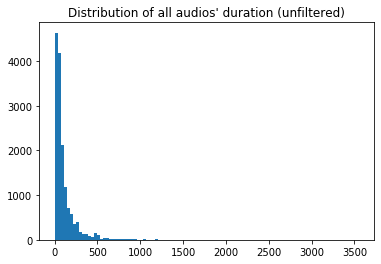

In [14]:
plt.hist(df['length'], bins=100)
plt.title("Distribution of all audios' duration (unfiltered)")
plt.show()

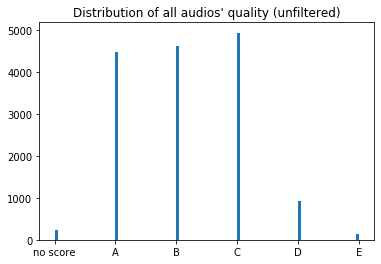

In [15]:
plt.hist(df['quality'], bins=100)
plt.title("Distribution of all audios' quality (unfiltered)")
plt.show()

Filtered plot of the distributions


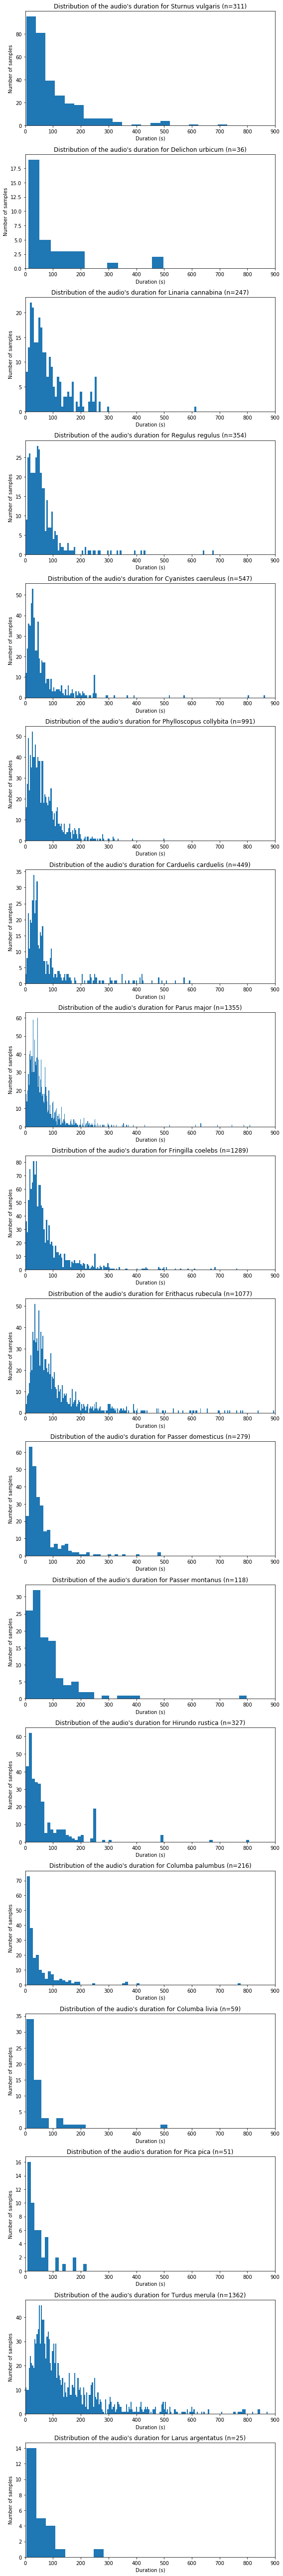

Number of total valid samples: 9093


In [16]:
print("Filtered plot of the distributions")
plot_distrib(df, BirdsList)